<h2>SHIP DETECTION USING SATELLITE IMAGERY</h2>

<h3>OBJECTIVES</h3>

1. Data preprocessing: load data (from JSON), get pixel data into the right format and shape.<br>
2. Data exploration and visualization of the *ship* class and the sub-classes of the *no_ship* class (*land*, *partial_ship*, and *hard*).<br>
3. Compare the performance of various ML models using Cross-Validation (5-fold):<br>
    3.1. Logistic Regression (LR)<br>
    3.2. Linear Discriminant Analysis (LDA)<br>
    3.3. K-Nearest Neighbor (KNN)<br>
    3.4. Gaussian Naive Bayes (NB)<br>
    3.5. Decision Tree (DT)<br>
    3.6. Random Forest (RF)<br>
    3.7. XGBoost (XGB)<br>
    3.8. SVM Linear Kernel (LSVM)<br>
    3.9. SVM 2nd Order Polynomial Kernel (P2SVM)<br>
    3.10. SVM 3rd Order Polynomial Kernel (P3SVM)<br>
    3.11. SVM RBF Kernel (RSVM)<br>
4. Perform the comparison outlined in (3) using the following features:<br>
    4.1. Native RGB pixel value.<br>
    4.2. Z-score standardized RGB pixel value.<br>
    4.3. HOG (Histogram of Oriented Gradient).<br>
5. Assess the best perfoming models in (3) and the associated features in (4).
6. Assess the prediction errors between the *ship* class and the 3 *no_ship* sub-classes.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import os, json
from tqdm import tqdm
import skimage
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

shipsnet_json_path = '../input/ships-in-satellite-imagery/shipsnet.json'
shipsnet_png_dirpath = '../input/ships-in-satellite-imagery/shipsnet/shipsnet/'

<h3>JSON Data Format</h3>

The loaded JSON object contains *data*, *label*, *location*, and *scene_ids* lists.

* *data* contains pixel values for each 80x80 RGB image stored as a list of 19200 (80x80x3) integers where the first 6400 integers contain the Red channel values, followed by the Green and Blue channels, consecutively. The image is stored in row-major order so that the first 80 integers of the array are the red channel values of the first row of the image.<br>

* The i-th value in *labels*, *scene_ids*, and *locations*, each corresponds to the i-th image chip in the *data* list.<br>

* An element of *locations* contains [longitude, latitude] of the center pixel of the image chip in degree decimal.<br>

* An element of *scene_ids* is a string of scene_id of the original satellite image from which the image chip was extracted.<br>

In [2]:
'''
Load the shipsnet data in json into pandas dataframe.
Args:
    file_path : full path of the .JSON file
Return:
    pandas df with the following columns:
    'data', 'labels', 'locations' [longitude, latitude], 'scene_ids'
    The 'data' column shape will be M x 19200, M = number of RGB img chips (80x80x3)
    Structure of 19200 pixel values = [6400 R, 6400 G, 6400 B]
'''
def load_shipsnet_json(file_path):
    with open(file_path) as json_file:
        ship_data_json = json.load(json_file)
    shipsnet_df = pd.DataFrame(ship_data_json)
    return shipsnet_df

In [3]:
'''
Load data from JSON file.
'''
shipsnet_df = load_shipsnet_json(shipsnet_json_path)
shipsnet_df.head()

data  labels  \
0  [82, 89, 91, 87, 89, 87, 86, 86, 86, 86, 84, 8...       1   
1  [76, 75, 67, 62, 68, 72, 73, 73, 68, 69, 69, 6...       1   
2  [125, 127, 129, 130, 126, 125, 129, 133, 132, ...       1   
3  [102, 99, 113, 106, 96, 102, 105, 105, 103, 10...       1   
4  [78, 76, 74, 78, 79, 79, 79, 82, 86, 85, 83, 8...       1   

                                   locations             scene_ids  
0    [-118.2254694333423, 33.73803725920789]  20180708_180909_0f47  
1    [-122.33222866289329, 37.7491755586813]  20170705_180816_103e  
2  [-118.14283073363218, 33.736016066914175]  20180712_211331_0f06  
3   [-122.34784341495181, 37.76648707436548]  20170609_180756_103a  
4   [-122.34852408322172, 37.75878462398653]  20170515_180653_1007

<h3>Data Reshaping</h3>

* The *data* column in shipsnet_df is a list of list in the shape of (*num_samples*, *num_features*) where *num_samples* = 4000, *num_features* = 80x80x3 = 19200.<br>
* We will transform *data* into two numpy arrays of the following shapes:<br>
    * (*num_sample*, *num_row*, *num_sample*, *num_channel*) or (4000, 80, 80, 3)<br>

In [4]:
'''
Transform data to chips RGB in 8-bit np array.
Output shape: (num_smples, num_rows, num_cols, num_channels)
For data in shipsnet.json:
num_samples = 4000
num_rows = 80
num_cols = 80
num_channles = 3 (RGB)
This is also the data shape supported by conv2D in keras.
'''
def get_X_chips_rgb(shipsnet_df, data_col='data', channels=3, rows=80, cols=80):
    num_samples = len(shipsnet_df[data_col])
    len_data    = len(shipsnet_df[data_col][0])     # len_data = 19200 for 80x80 RGB chips 
    assert len_data == channels * rows * cols
    X = np.zeros((num_samples, len_data), dtype=np.uint8)
    for idx in range(num_samples):
        X[idx,:] = np.array(shipsnet_df[data_col][idx]).astype(dtype=np.uint8)
    X_rgb_chips = X.reshape(-1, channels, rows, cols)
    X_chips_rgb = X_rgb_chips.transpose([0, 2, 3, 1])
    assert (X_chips_rgb[0][0][0] == np.array([shipsnet_df.data[0][0], shipsnet_df.data[0][6400], shipsnet_df.data[0][12800]])).all(), 'Data reshaping ERROR'
    return X_chips_rgb

In [5]:
'''
Separate the chips, but keep the RGB values for each pixel (line,sample) together.
Output shape = (num_row, num_col, num_channel)
'''
X_chips_rgb = get_X_chips_rgb(shipsnet_df)
print(X_chips_rgb.shape)

(4000, 80, 80, 3)


<h3>Samples in Class and Subclasses</h3>
    
As explained in the Data Card, there are 1000 samples of the *ship* class and 3000 samples of the *no_ship* class.<br>
    
The *no_ship* class encompasses samples from three sub-classes with 1000 samples each:<br>
    
* *land* : land cover features - water, vegetation, bare earth, buildings, etc.<br>
* *partial_ship* : contains portions of ships.<br>
* *hard* : image chips that were previously mislabeled by ML models, typically caused by bright pixels from sun glints, may contain strong linear features (from structure over the water like bridges, piers, and jetties).<br>
  
We will analyze the classification errors produced by the best classification model and determine if the inclusion of partial ships, smaller vessels (such as boats), and structures over the water (bridges, piers, jetties) in the *no_ship* class contribute to these errors. 
    
<h3>Data Augmentation</h3>

We recognize the unbalanced number of samples between the *ship* and *no_ship* classes. A natural step to take is to augment the *ship* class with additional samples derived from the existing samples. However, it will be interesting to see how this imbalance of samples affect the accuracy of models. Therefore, for this round of experiments, we will proceed **without** augmenting the samples in the *ship* class.<br>

Questions to ponder: <br>
* Will the inclusion of *partial_ship* sub-class in *no_chip* class lead to more prediction errors?
* Will smaller number of samples for *ship* class lead to greater number of prediction error where more *ship* samples are misclassified as *no_ship*?<br>
* Will data augmentation to ameliorate the imbalanced classes reduce these errors?


In [6]:
'''
Get the sample class labels:
    0 : no_ship
    1 : ship
'''
y = shipsnet_df['labels']
y.value_counts()

labels
0    3000
1    1000
Name: count, dtype: int64

In [7]:
'''
Split the no_ship class into 3 sub-classes: 
    0: land
    1: partial_ship
    2: hard
The ship class will receive a new class label 3.
The new labeling will help us to understand the source of prediction errors.
'''
def split_no_ship_label(shipsnet_df):
    split_y = shipsnet_df['labels'].copy()
    split_y.rename('4-class labels')
    ship_indexes = shipsnet_df.index[shipsnet_df['labels'] == 1]
    split_y[ship_indexes] = 3
    no_ship_indexes = shipsnet_df.index[shipsnet_df['labels'] == 0]
    split_y[no_ship_indexes[1000:2000]] = 1   # partial_ship
    split_y[no_ship_indexes[2000:3000]] = 2   # hard samples (previously misclassified by some ML models)
    split_y_labels = split_y.replace({0: 'land', 1: 'partial_ship', 2: 'hard', 3: 'ship'})
    return split_y, split_y_labels

In [8]:
split_y, split_y_labels = split_no_ship_label(shipsnet_df)
print(split_y.value_counts())
print(split_y_labels.value_counts())

labels
3    1000
0    1000
1    1000
2    1000
Name: count, dtype: int64
labels
ship            1000
land            1000
partial_ship    1000
hard            1000
Name: count, dtype: int64


<h3>Data Visualization</h3>

We now inspect some image samples (randomly selected) from the *ship* class and the *no_ship* sub-classes (*land*, *partial-ship*, *hard).

In [9]:
"""
Display a few of each sub-class of the no-ship samples.
Args:
    X: np.array(data_idx, row, col, channel)
    y_labels: list of class label (string) where y_labels[idx] holds the class label for X[idx]
    class_label: string of class label to display in ['ship', 'land', 'partial_ship', 'hard']
    num_display: int, num of imgs of class_label to display (randomly selected) fro X.
"""
def plot_img_samples_by_class(X, y_labels, class_label, num_display=25, disp_grid=(5,5), seed=11):
    class_idx_list = (y_labels == class_label)
    class_data = X[class_idx_list]
    #print(f"class_data.shape={class_data.shape}")
    np.random.seed(seed)
    display_idx = np.random.randint(size=num_display, low=0, high=class_data.shape[0])
    fig = plt.figure(figsize=(15, 15))
    for d_idx in range(num_display):
        fig.add_subplot(disp_grid[0], disp_grid[1], d_idx+1)
        plt.imshow(class_data[display_idx[d_idx]])
        plt.axis('off')
        plt.title(class_label + '_' + str(display_idx[d_idx]))       

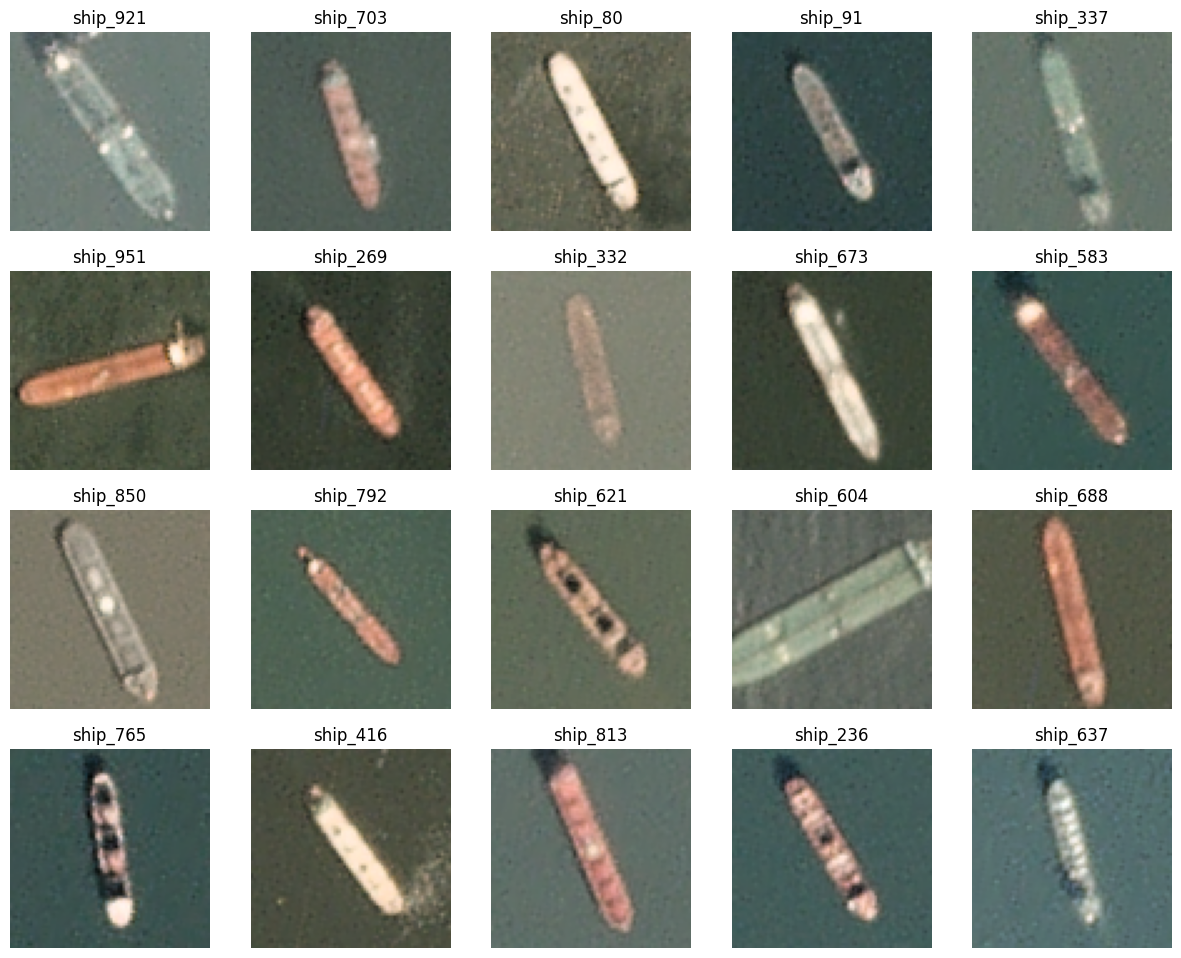

In [10]:
'''
Display ship samples.
'''
plot_img_samples_by_class(X_chips_rgb, split_y_labels, class_label='ship', num_display=20)

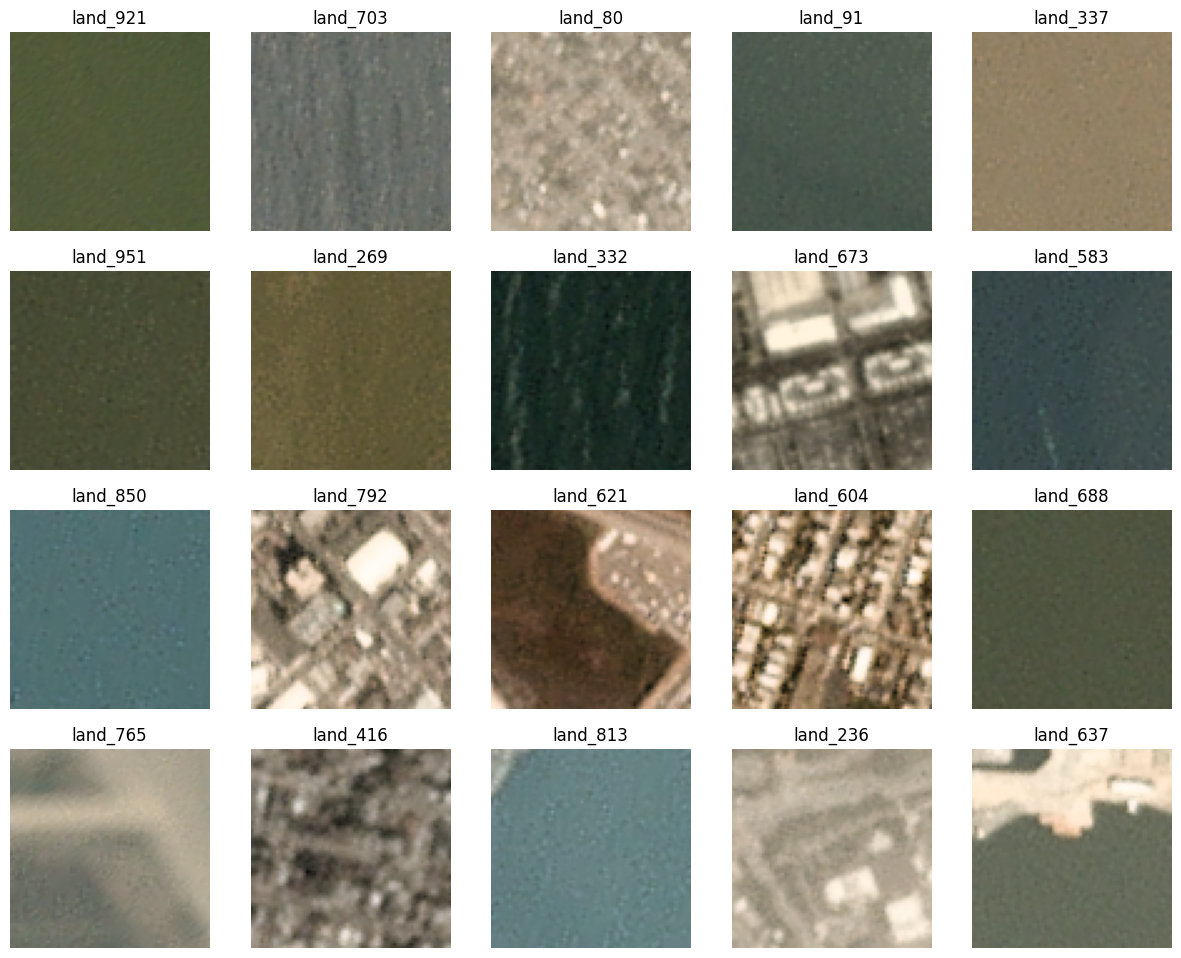

In [11]:
'''
Display land samples.
'''
plot_img_samples_by_class(X_chips_rgb, split_y_labels, class_label='land', num_display=20)

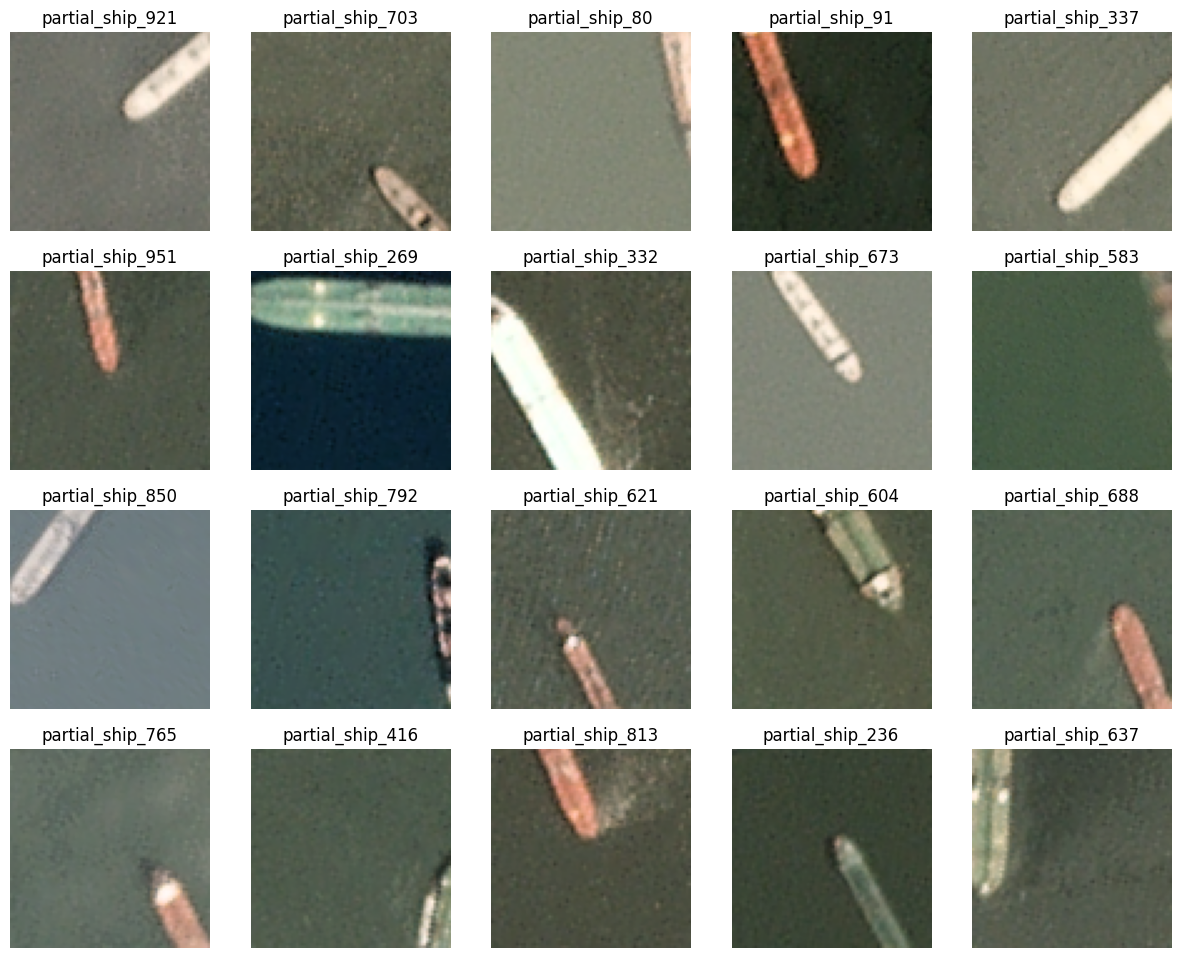

In [12]:
'''
Display partial_ship samples.
'''
plot_img_samples_by_class(X_chips_rgb, split_y_labels, class_label='partial_ship', num_display=20)

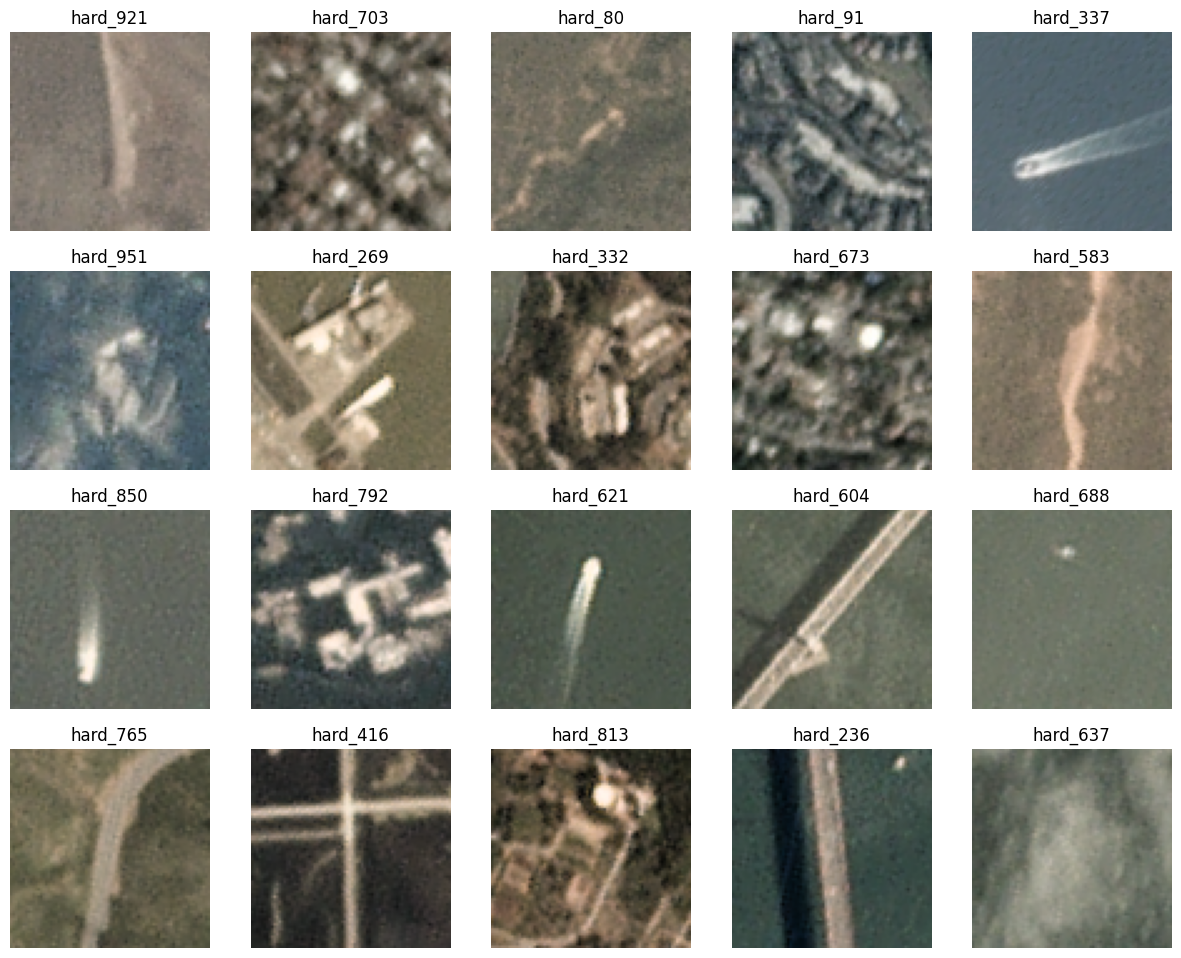

In [13]:
'''
Display hard samples. We may find a mix between land, water, partial ships, smaller boats, or structures near or above water.
'''
plot_img_samples_by_class(X_chips_rgb, split_y_labels, class_label='hard', num_display=20)

<h3>What We Learned From Data Visualization</h3>

* The *ship* class may contain samples of partial ships (see *ship_604* sample).<br>
* The *land* class contains land (with and without structures), but also contains samples of empty water and/or water edges/shorelines.<br>
* The *partial_ship* class contains samples that capture 50% or more of the ship structure. What is the threshold for labeling a sample as *partial_ship*?<br>
* The *hard* class contains a mixture of land (with and without structures), structures above water (briges, piers), small boats (with long wakes), cloud covers.<br>

<h3>Classifier Models Evaluation</h3>

List of binary classifiers to compare:

<ol>
    <li>Logistic Regression (LR)</li>
    <li>Linear Discriminant Analysis (LDA)</li>
    <li>K-Nearest Neighbor (KNN)</li>
    <li>Gaussian Naive Bayes (NB)</li>
    <li>Decision Tree (DT)</li>
    <li>Random Forest (RF)</li>
    <li>XGBoost (XGB)</li>
    <li>SVM Linear Kernel (LSVM)</li>
    <li>SVM 2nd Order Polynomial Kernel (P2SVM)</li>
    <li>SVM 3rd Order Polynomial Kernel (P3SVM)</li>
    <li>SVM RBF Kernel (RSVM)</li>
</ol>

* Each model is evaluated using 5-fold cross-validation.
* Scoring metric = *f1*, this is selected over *accuracy* since we have a case of class imbalance (samples of *no_ship* class > samples of *ship* class).<br>
* *StratifiedKFold()* is utilized to preserve the proportion of the class samples. This is important since the *ship* class has a lot fewer samples.
* The CV test score are presented as: *mean*, *std*, *min*, *median*, *max*<br>
* The accuracy boxplot is also generated for each model.<br>
* The experiments will be performed using 3 features:
    1. Original RGB pixel values (without normalization/scaling).
    2. RGB pixel values standardized using Z-score.
    3. Histogram of Oriented Gradient (HOG) features.

In [14]:
from sklearn import model_selection, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np

'''
Args:
    X            : input data in shape = (num_samples, num_features)
    y            : class label in shape = (num_samples,)
    title_info   : string identifier added to boxplot title
    shuffle      : boolean (default=False) if True the Train-Test split in k-fold cross validation is with uniform random distribution.
    random_state : int, random seed used only if shuffle=True
    
Returns:
    results      : list of M np.array where M = num of models, each np.array holds the test accuracy of each of the k-fold CV run of a given model.
    names        : list of M strings of model names in results.
'''
def compare_models(X, y, k_cv=10, tolerance=0.01, title_info=None, shuffle=False, random_state=0, scoring='f1'):
    models = {}
    models['LR'] = LogisticRegression(tol=tolerance, max_iter=100, solver='sag')
    models['LDA'] = LinearDiscriminantAnalysis(tol=tolerance)
    models['KNN'] = KNeighborsClassifier(n_neighbors=9)
    models['NB'] = GaussianNB()
    models['DT'] = DecisionTreeClassifier()
    models['RF'] = RandomForestClassifier()
    models['XGB'] = XGBClassifier()
    models['LSVM'] = SVC(kernel='linear')
    models['P2SVM'] = SVC(kernel='poly', degree=2)
    models['P3SVM'] = SVC(kernel='poly', degree=3)
    models['RSVM'] = SVC(kernel='rbf')

    model_results = {}
    title_str = str(k_cv) + '-fold Cross-Validation Scoring=' + scoring
    if title_info:
        title_str += ' - ' + title_info
    print(title_str)
    print('Model:\tMean\tStd\tMin\tMedian\tMax')
    
    kfold = model_selection.StratifiedKFold(n_splits=k_cv, shuffle=shuffle, random_state=random_state)
    
    for name, model in models.items():
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        model_results[name] = cv_results
        print(f'{name}:\t{cv_results.mean():.4f}\t{cv_results.std():.4f}\t{cv_results.min():.4f}\t{np.median(cv_results):.4f}\t{cv_results.max():.4f}')
    
    fig = plt.figure()
    #suptitle_str = str(k_cv) + "-fold Cross Validation Model Comparison"
    #if title_info:
    #    suptitle_str += ' - ' + title_info
    fig.suptitle(title_str)
    ax = fig.add_subplot()
    plt.boxplot(list(model_results.values()))
    ax.set_xticklabels(list(model_results.keys()))
    plt.xlabel('Models')
    plt.ylabel(f'Scoring={scoring}')
    plt.show()
    return model_results

In [15]:
'''
Flatten the image RGB data into 1D feature array for use in ML model training.
'''

X_chips_rgb_1d = X_chips_rgb.reshape(-1, 80*80*3)
print(X_chips_rgb_1d.shape)
print(y.shape)

num_fold = 5

(4000, 19200)
(4000,)


<h3>Model Evaluation Using Original RGB Features</h3>

5-fold Cross-Validation Scoring=f1
Model:	Mean	Std	Min	Median	Max
LR:	0.8212	0.0199	0.8000	0.8198	0.8543
LDA:	0.7165	0.0127	0.6957	0.7169	0.7356
KNN:	0.8352	0.0141	0.8241	0.8304	0.8628
NB:	0.5087	0.0269	0.4639	0.5126	0.5419
DT:	0.7954	0.0103	0.7862	0.7901	0.8146
RF:	0.9142	0.0199	0.8889	0.9048	0.9406
XGB:	0.9367	0.0126	0.9235	0.9340	0.9552
LSVM:	0.8253	0.0090	0.8095	0.8293	0.8357
P2SVM:	0.8986	0.0099	0.8878	0.8945	0.9136
P3SVM:	0.8937	0.0162	0.8765	0.8883	0.9238
RSVM:	0.9309	0.0123	0.9128	0.9278	0.9487


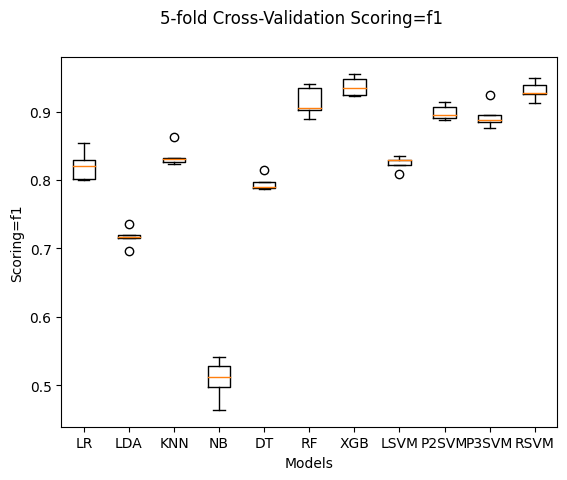

In [16]:
'''
Compare models using pixel data without any normalization/scaling.
'''

model_cv_f1 = compare_models(X_chips_rgb_1d, y, k_cv=num_fold, shuffle=True, random_state=49, scoring='f1')

<h3>Model Evaluation Using Z-Score Standardized RGB Pixel Values</h3>

In [17]:
'''
Apply the Z-score standardization: each pixel value is standardized to zero mean and unit variance.
StandardScaler.fit_transform() expects input X in shape (num_samples, num_features)
'''
scaler = StandardScaler()
X_chips_rgb_1d_zscore = scaler.fit_transform(X_chips_rgb_1d)

5-fold Cross-Validation Scoring=f1 - z-score
Model:	Mean	Std	Min	Median	Max
LR:	0.8139	0.0062	0.8027	0.8164	0.8192
LDA:	0.7165	0.0127	0.6957	0.7169	0.7356
KNN:	0.8202	0.0202	0.7938	0.8168	0.8499
NB:	0.5087	0.0269	0.4639	0.5126	0.5419
DT:	0.8016	0.0138	0.7862	0.7972	0.8267
RF:	0.9060	0.0170	0.8859	0.9101	0.9299
XGB:	0.9367	0.0126	0.9235	0.9340	0.9552
LSVM:	0.8213	0.0084	0.8113	0.8244	0.8318
P2SVM:	0.7148	0.0376	0.6688	0.7307	0.7688
P3SVM:	0.6541	0.0416	0.5926	0.6834	0.6916
RSVM:	0.9279	0.0136	0.9072	0.9282	0.9433


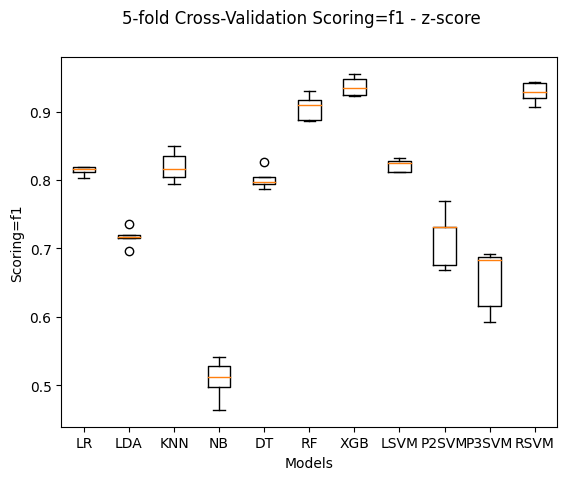

In [18]:
'''
Compare models using Z-score standardized pixel values with f1 scoring.
'''
zscore_model_cv_f1 = compare_models(X_chips_rgb_1d_zscore, y, k_cv=num_fold, title_info='z-score',
                                    shuffle=True, random_state=49, scoring='f1')

<h3>Model Evaluation Using HOG Features</h3>

This is a computer vision problem, thus we should look into computer vision algorithms that may help in improving the model performance.<br>

One of popular image registration algorithms in computer vision is __[SIFT](https://en.wikipedia.org/wiki/Scale-invariant_feature_transform/)__ (Scale Invariant Feature Transform). SIFT employs histogram of gradients as a descriptor of an interest point. This descriptor facilitates the matching of corresponding interest points in different images as a precursor to image co-registration.<br>

This knowledge leads us to the Histogram of Oriented Gradient (HOG) feature which is very similar to the SIFT interest point descripor.<br>

Here, we generate the HOG features using 10x10 pixels per cell, 2x2 cells per block, producing a feature vector of 1764 dimension (more than 90% dimensionality reduction from the original 19,200 features from the RGB channels). The dimensionality reduction of our feature space will also speed up the model evaluation.<br>

In [19]:
'''
Start by converting the RGB pixels into grayscale.
Then generating the HOG feature vector for each 80x80 image.
We use 10x10 pixels per cell and 2x2 cells per block with 9 bins for gradient histograms.
Return the flattened HOG descriptor.
'''
def rgb_to_hog(rgb_chips):
    X_grayscale = skimage.color.rgb2gray(rgb_chips, channel_axis=1)
    X_hog = []
    for idx in tqdm(range(X_grayscale.shape[0])):
        hog = skimage.feature.hog(X_grayscale[idx], 
                                  pixels_per_cell=(10, 10), 
                                  cells_per_block=(2, 2),  
                                  feature_vector=True)
        X_hog.append(hog)
    X_hog = np.array(X_hog)
    return X_hog

In [20]:
'''
Note that skimage.color.rgb2gray(X) expects input X to be in the shape of (num_samples, 3, num_row, num_col).
Our data array is currently in the shape of (num_samples, num_row, num_col, 3).
Need to reshape our data array.
'''
X_rgb_chips = X_chips_rgb.transpose([0, 3, 1, 2])
print(X_rgb_chips.shape)

'''
Generate the HOG features. 
Note that the flattened HOG feature vector contains 1764 elements.
This gives us more than 90% dimensionality reduction from the original feature size of 19200.
'''

X_hog = rgb_to_hog(X_rgb_chips)
print(X_hog.shape)

(4000, 3, 80, 80)


100%|██████████| 4000/4000 [00:11<00:00, 339.76it/s]

(4000, 1764)


5-fold Cross-Validation Scoring=f1 - HOG
Model:	Mean	Std	Min	Median	Max
LR:	0.9432	0.0096	0.9316	0.9418	0.9574
LDA:	0.8779	0.0138	0.8537	0.8772	0.8922
KNN:	0.9555	0.0084	0.9466	0.9540	0.9685
NB:	0.7957	0.0171	0.7778	0.7899	0.8278
DT:	0.8285	0.0204	0.8000	0.8255	0.8585
RF:	0.9303	0.0174	0.9067	0.9282	0.9570
XGB:	0.9354	0.0161	0.9105	0.9370	0.9550
LSVM:	0.9268	0.0055	0.9216	0.9242	0.9372
P2SVM:	0.9570	0.0045	0.9497	0.9570	0.9628
P3SVM:	0.9673	0.0094	0.9545	0.9671	0.9801
RSVM:	0.9803	0.0091	0.9669	0.9798	0.9925


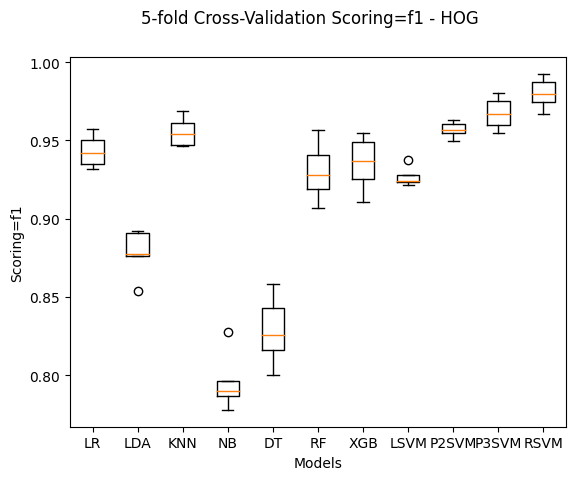

In [21]:
'''
Compare models using HOG features with f1 scoring.
'''

hog_model_cv_f1 = compare_models(X_hog, y, k_cv=num_fold, title_info='HOG', shuffle=True, random_state=49, scoring='f1')

<h3>Analysis on Model Evaluation Results</h3>

* The HOG feature is highly effective for this dataset with the top 5 models being:<br>
    * SVM with RBF kernel (median f1: 0.9798)<br>
    * SVM with 3rd-order polynomial kernel (median f1: 0.9671)<br>
    * SVM with 2nd-order polynomial kernel (median f1: 0.9570)<br>
    * KNN with n_neighbors=9 (median f1: 0.9540)<br>
    * Logistic Regression (median f1: 0.9394)<br>
* The Radial Basis Function (RBF) is a popular kernel to use in SVM classifier. <br>
    * It works similarly to the KNN (and KNN made it to the top 5 models).<br>
    * With the advantage of lower space complexity since SVM stores only the support vectors obtained during training, and not the entire dataset as in the case of KNN.
* It is interesting to note that simpler models like the Logistic Regression and K-NN achieved high f1 score using HOG features.
* The HOG features improves the f1 score for all models across the board.<br>
    * Gaussian Naive Bayes (NB) demonstrated the greatest f1 improvement (from 0.5126 to 0.7899)<br>
* The Z-score standardization did not improve the models f1 score. In fact, the f1 score drops in some models.
* XGBoost overview:<br>
    * Had the best median f1 score (0.9340) with original RGB pixels and the Z-score.<br>
    * HOG features barely moved the f1 score of XGBoost.<br>

<h3>Error Analysis</h3>

We select SVM-classifier with RBF kernel paired with the HOG features as the system of choice for ship detection.<br>

We repeat the 5-fold cross-validation experiments with this model and get the predictions on the test datasets.<br>

Rather than generating a 2x2 confusion matrix, we want to evaluate the level of *cross-talk* between the *ship* class and the *no_ship* sub-classes.<br>

We will visualize the images of prediction errors. This can provide better insights into the nature of errors and whether augmenting the *ship* class may help.


In [22]:
'''
Perform 5-fold cross-validation with the SVM-RBF model and get the predictions (of the test datasets in CV folds).
'''
model =  SVC(kernel='rbf')
kfold = model_selection.StratifiedKFold(n_splits=5, shuffle=True, random_state=49)
y_pred = model_selection.cross_val_predict(model, X_hog, y, cv=kfold)

print(metrics.classification_report(y, y_pred, target_names=['no_ship', 'ship']))

'''
Pack the y, y_pred, and the subclass-name of y in pandas df
    y      : original class label (0: no_ship, 1: ship)
    y_pred : predicted class label
    name   : original class name
    subname: subclass name (land, partial_ship, hard, ship)
'''
y_label = y.replace({0: 'no_ship', 1: 'ship'})
test_predictions = pd.DataFrame({'y':y, 'y_pred':y_pred, 'name':y_label, 'predname':y_pred, 'subname':split_y_labels})
test_predictions.predname = test_predictions.predname.replace({0: 'no_ship', 1: 'ship'})

              precision    recall  f1-score   support

     no_ship       0.99      1.00      0.99      3000
        ship       0.99      0.97      0.98      1000

    accuracy                           0.99      4000
   macro avg       0.99      0.98      0.99      4000
weighted avg       0.99      0.99      0.99      4000



<h4>Error Categories</h4>

1. *ship* misclassified as *no_ship* (too bad, we cannot identify which subclass the *ship* is being classified as --- perhaps run a 4-way classifier?)
2. *land* misclassified as *ship*
3. *partial_ship* misclassified as *ship*
4. *hard* misclassified as *ship*

In [23]:
err_idx = test_predictions.loc[test_predictions.y != test_predictions.y_pred].index.to_numpy(dtype=int)
print(f'Total prediction error = {err_idx.shape[0]}')

'''Error Category 1 (ship -> no_ship)'''
err_idx_1 = test_predictions.loc[(test_predictions.name == 'ship') & (test_predictions.predname != 'ship')].index.to_numpy(dtype=int)
print(f'Category 1 error (ship -> no_ship)\t= {err_idx_1.shape[0]}')

'''Error Category 2 (land -> ship)'''
err_idx_2 = test_predictions.loc[(test_predictions.subname == 'land') & (test_predictions.predname == 'ship')].index.to_numpy(dtype=int)
print(f'Category 2 error (land -> ship)\t\t= {err_idx_2.shape[0]}')

'''Error Category 3 (partial_ship -> ship)'''
err_idx_3 = test_predictions.loc[(test_predictions.subname == 'partial_ship') & (test_predictions.predname == 'ship')].index.to_numpy(dtype=int)
print(f'Category 3 error (partial_ship -> ship)\t= {err_idx_3.shape[0]}')

'''Error Category 4 (hard -> ship)'''
err_idx_4 = test_predictions.loc[(test_predictions.subname == 'hard') & (test_predictions.predname == 'ship')].index.to_numpy(dtype=int)
print(f'Category 4 error (hard -> ship)\t\t= {err_idx_4.shape[0]}')

Total prediction error = 39
Category 1 error (ship -> no_ship)	= 28
Category 2 error (land -> ship)		= 0
Category 3 error (partial_ship -> ship)	= 3
Category 4 error (hard -> ship)		= 8


In [24]:
def plot_error_chips(X, pred_err_df, pred_err_idx, grid=(6,5), figsize=(20,20)):
    fig = plt.figure(figsize=figsize)
    assert len(pred_err_idx) <= grid[0]*grid[1], 'Insufficient display grid'
    for disp_idx in range(len(pred_err_idx)):
        data_idx = pred_err_idx[disp_idx]
        fig.add_subplot(grid[0], grid[1], disp_idx+1)
        plt.imshow(X[data_idx])
        plt.axis('off')
        row = pred_err_df.loc[data_idx, ['name', 'predname', 'subname']]
        plt.title(str(row[0]) + '-->' + str(row[1]) + '\nsubclass= ' + str(row[2]) + ', idx=' + str(data_idx))

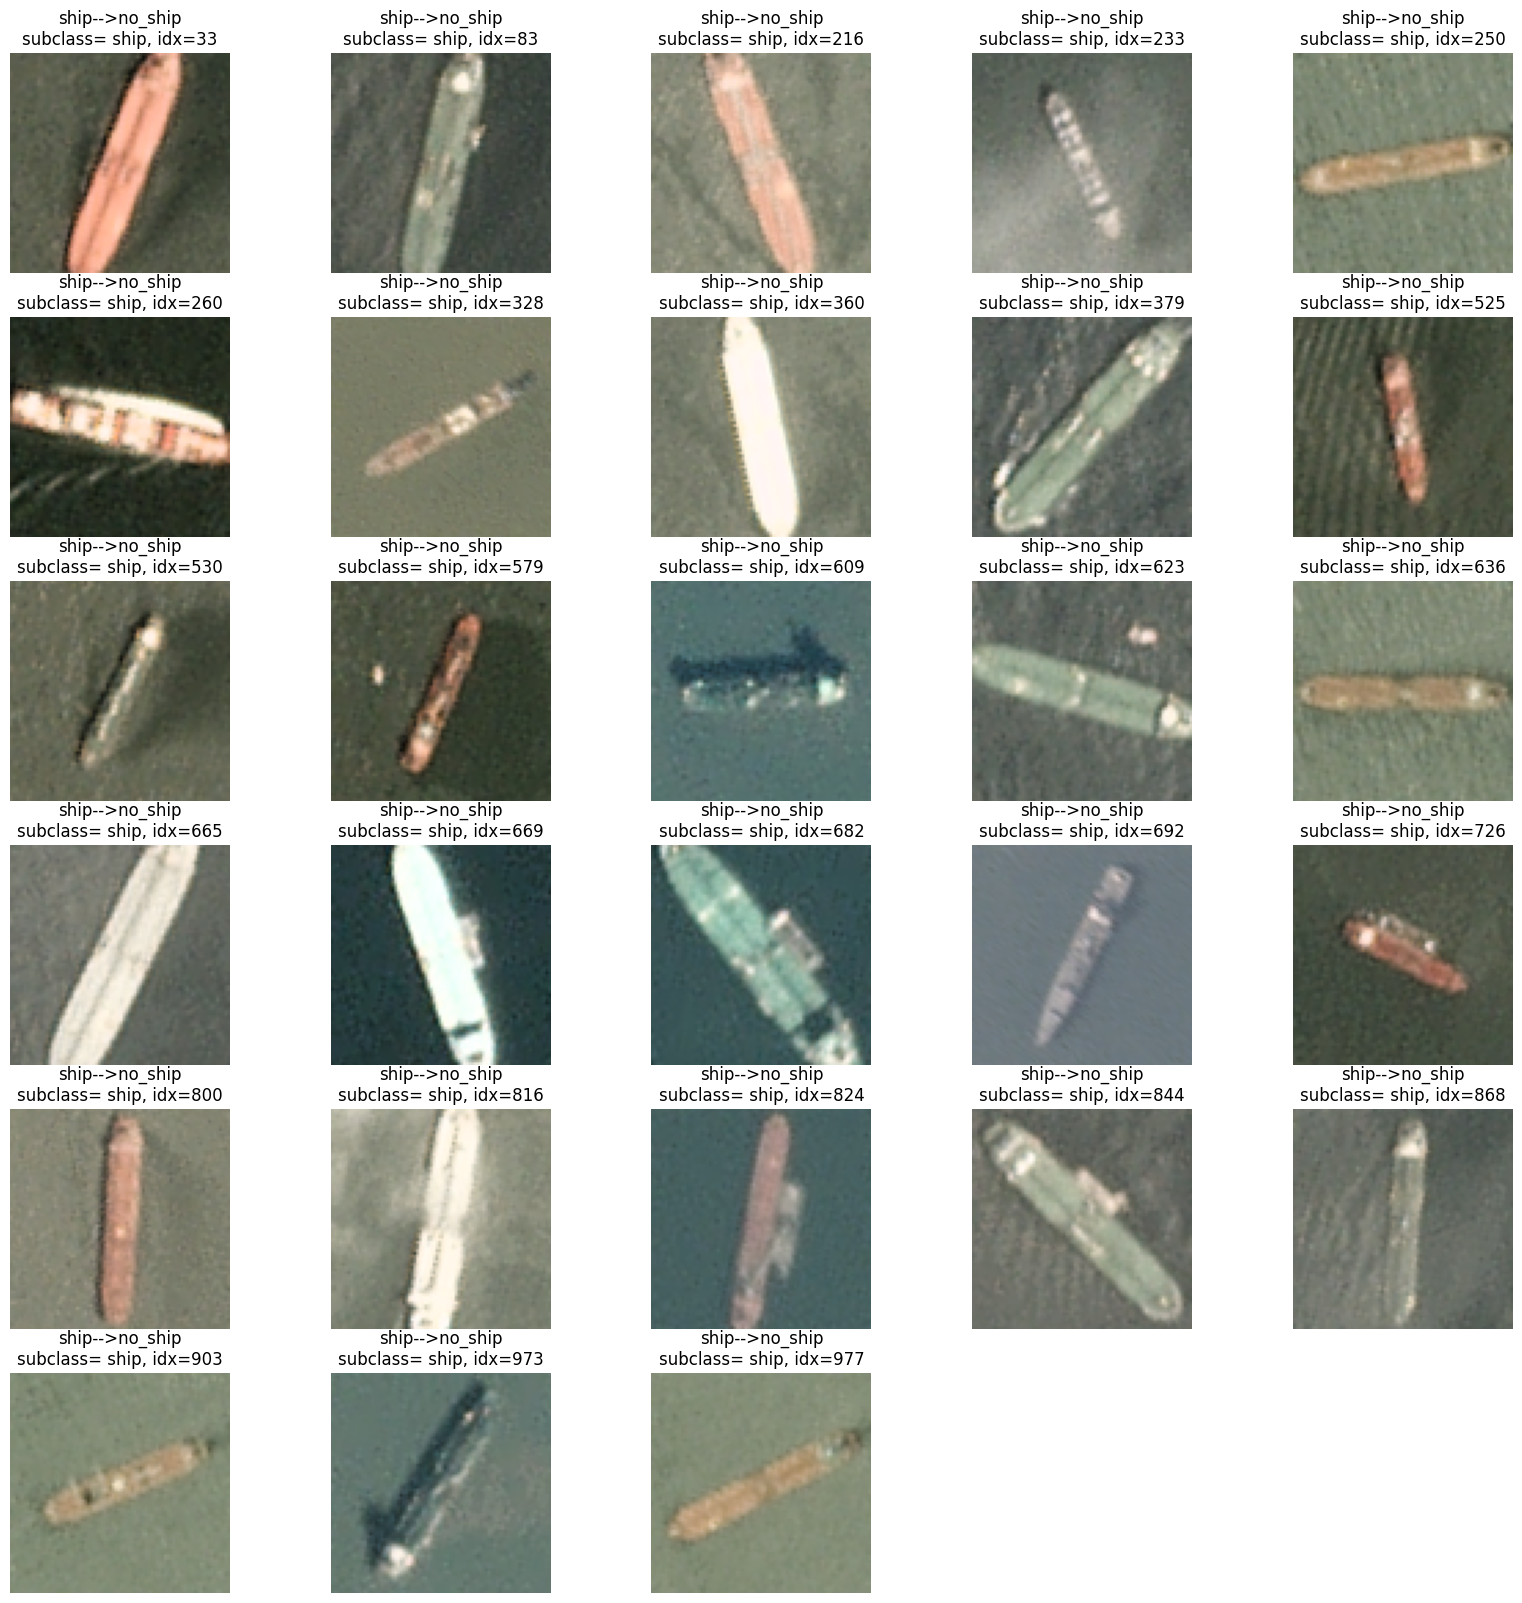

In [25]:
'''Visualize Error Category 1 (ship -> no_ship)'''

plot_error_chips(X_chips_rgb, test_predictions, err_idx_1, grid=(6,5))

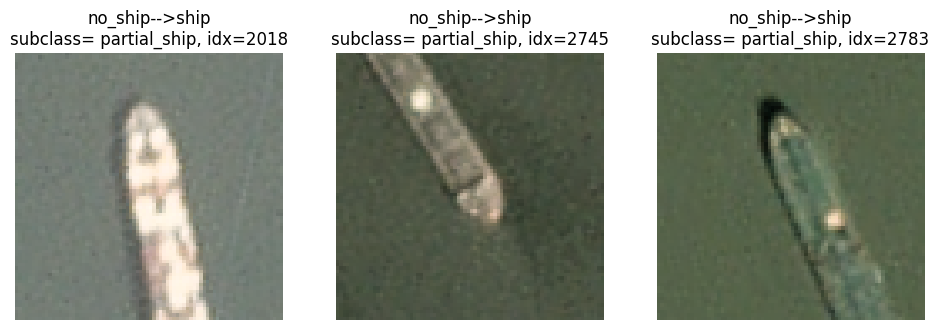

In [26]:
'''Error Category 2 (land -> ship) is empty. Nothing to visualize.'''

'''Visualize Error Category 3 (partial_ship -> ship)'''

plot_error_chips(X_chips_rgb, test_predictions, err_idx_3, grid=(1,5))

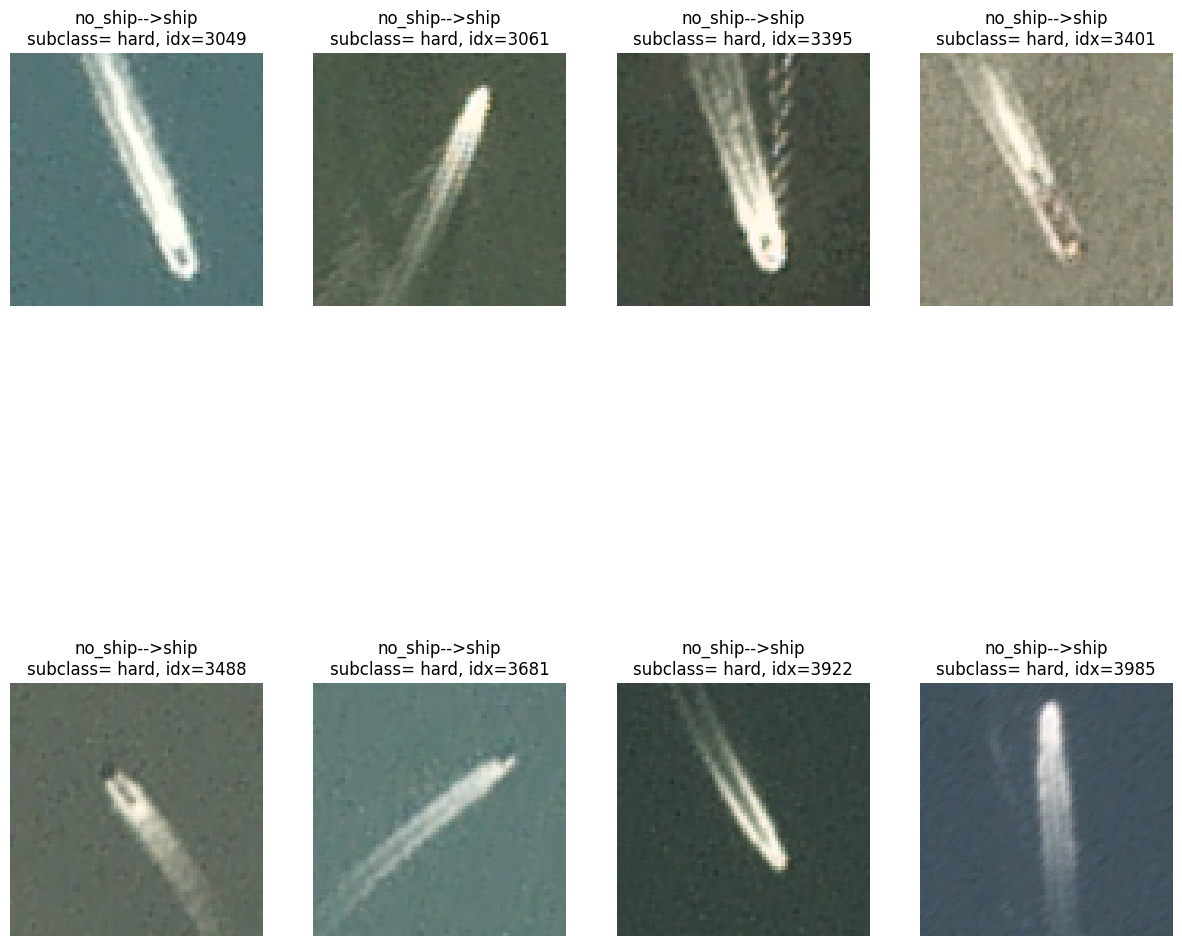

In [27]:
'''Visualize Error Category 4 (hard -> no_ship)'''

plot_error_chips(X_chips_rgb, test_predictions, err_idx_4, grid=(2,4), figsize=(15,15))

<h3>Observations From Errors</h3>

* There are 39 prediction errors resulting in 0.99 accuracy.<br>
    * 28 samples from *ship* class.<br>
    * 11 samples from *no_ship* class.<br>
* Is the lopsided error contribution above the result of the unbalanced class size?<br>
    * The SVM model keeps a fraction of the training vectors as support vectors.<br>
    * It is likely that the larger class, having greater number of training samples, contributes more SVM support vectors than the smaller class.<br>
    * Thus, the SVM classifier may be biased towards making the correct classification for the larger class.<br>
    * It would be interesting to interrogate the SVM model on which support vectors are involved in the misclassifications of these 28 *ship* samples, and whether the majority of those support vectors are from the *partial_ship* subclass as part of the *no_ship* class.<br>
    * This raises the argument for augmenting the smaller *ship* class to even the training field for the SVM model.<br>
* Ten out of 28 misclassified *ship* samples capture large ships whose hulls touches or extends beyond the image boundaries, thus bringing them closer to the *partial_ship* subclass.
* Only three samples of *partial_ship* subclass are misclassified as *ship*, despite the subclass having the same number of samples as the *ship* class.
* Eight samples of *hard* subclass are misclassified as *ship*.<br>
    * All eight samples are images of smaller boats or vessels sailing and leaving long white wakes behind them.<br>
    * These white wakes are similar in shape to ships, and some samples in *ship* class exhibit saturated ship pixels due to sun glints, which looks white in color.<br>
    * The wakes generate high magnitude gradients in the perpendicular direction of the boats' path.<br>
    * Similar gradient patterns can be generated by large ships as captured by the HOG features.<br>
* What next:
    * Augmenting the *ship* class samples seems to hold the highest potential in reducing the prediction error of *ship* class.
    * If using HOG, we recommend limiting the image augmentation methods to vertical and horizontal flip, and 90 and 270 degree rotations. These transformations will prevent the introduction of black areas of *no-data* whose edges will add artificial gradients to the HOG features.
    * We generated the HOG features using 10x10 pixels cells, 2x2 cell block, and 9-bin histogram. Changing these parameters will affect the HOG feature dimensionality, which may have some influence on the model accuracy.
    * It will be interesting to transform the dataset into a 4-class dataset (*ship*, *land*, *partial_ship*, and *hard*) and evaluate some multi-class classifiers.
    


